In [1]:
% matplotlib inline

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
from glob import glob
import os
import numpy as np

import sys
sys.path.append('scripts')
import load_utils

# Preprocess CT scans for ROI segmentation

In [3]:
! python scripts/prepare_aorta_segmentation.py -h

usage: prepare_aorta_segmentation.py [-h] [--batch-size N] [--j J] [--n N]
                                     idir odir

Preprocess CT scans for ROI segmentation.

positional arguments:
  idir            input directory
  odir            output directory

optional arguments:
  -h, --help      show this help message and exit
  --batch-size N  batch size to load in RAM
  --j J           number of process to run simultaneously
  --n N           maximum number of samples to be processed


In [4]:
! rm -r ../DM_Data/RIII_test/*
! python scripts/prepare_aorta_segmentation.py ../DM_Data/RIII/ ../DM_Data/RIII_test/ --n=3
! ls ../DM_Data/RIII_test/

100%|█████████████████████████████████████████████| 4/4 [00:17<00:00,  4.39s/it]
0201R3011  0304R3039  1649R3008


# Train UNet over CT scans for ROI segmentation

In [5]:
! python scripts/train_aorta_segmentation.py -h

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
usage: train_aorta_segmentation.py [-h] [--batch-size N] [--epochs E]
                                   [--split S] [--j J]
                                   idir mdir

Train UNet over CT scans for ROI segmentation.

positional arguments:
  idir            input directory
  mdir            output model directory

optional arguments:
  -h, --help      show this help message and exit
  --batch-size N  batch size to load in RAM
  --epochs E      number of epochs
  --split S       train / test split: train = patient_ids[int(SPLIT *
                  len(patient_ids)):]
  --j J           number of process to run simultaneously


In [6]:
! rm -r ../DM_Data/RIII_test_model/*
! python scripts/train_aorta_segmentation.py ../DM_Data/RIII_test/ ../DM_Data/RIII_test_model/ --epochs=3

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Epoch 1/1
2018-02-15 19:13:16.930342: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-02-15 19:13:17.016336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:892] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-02-15 19:13:17.016669: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1030] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:1e.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2018-02-15 19:13:17.016703: I tensorflow/core/common_runtime/

In [7]:
! ls ../DM_Data/RIII_test_model/

unet_model


# UNet inference over CT scans, ROI segmentation

In [8]:
! python scripts/predict_aorta_segmentation.py -h

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
usage: predict_aorta_segmentation.py [-h] [--spacing S] [--batch-size N]
                                     [--TTA T] [--j J] [--pdir PDIR] [--n N]
                                     idir odir mpath

UNet inference over CT scans, ROI segmentation.

positional arguments:
  idir            input directory
  odir            output directory
  mpath           path to the model

optional arguments:
  -h, --help      show this help message and exit
  --spacing S     if included isotropic spacing of CT will be forced,
                  otherwise original spacing will be preserved
  --batch-size N  batch size to load in RAM
  --TTA T         whether to have test time augmentations, T in {0, 1, 2, 3}
  --j J           number 

In [9]:
! rm -r ../DM_Data/RIII_test_predicts/*
! python scripts/predict_aorta_segmentation.py ../DM_Data/RIII ../DM_Data/RIII_test_predicts ../DM_Data/RIII_models/unet_model --pdir=../DM_Data/RIII_test_pdir --batch-size=32 --spacing=1.0 --n=4

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
2018-02-15 19:14:14.893141: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-02-15 19:14:14.976371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:892] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-02-15 19:14:14.976716: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1030] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:1e.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2018-02-15 19:14:14.976753: I tensorflow/core/common_runtime/gpu/gpu_de

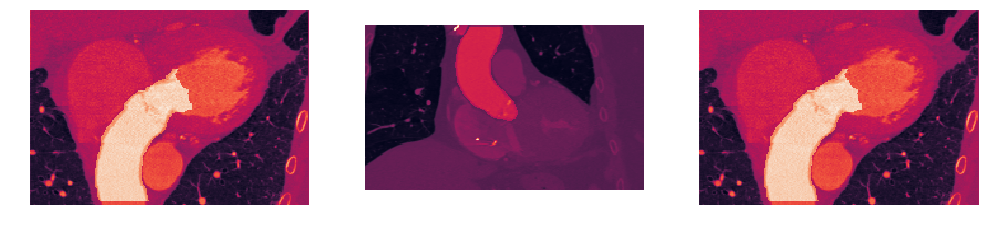

In [12]:
paths = glob('../DM_Data/RIII_test_predicts/*')
pdir = '../DM_Data/RIII_test_pdir'
plt.figure(figsize=(17, 7))

for i in range(3):
    path = np.random.choice(paths)
    mask = np.load(path)
    patch = np.load(os.path.join(pdir, os.path.basename(path)))
    plt.subplot(1, 3, i + 1)
    z, x, y = np.where(mask)
    plt.imshow(patch[:, int(x.mean())] + 750 * mask[:, int(x.mean())])
    plt.axis('off');

# Extract normal planes of CT scans and predicted masks

In [13]:
! python scripts/extract_normals.py -h

usage: extract_normals.py [-h] [--side SIDE] [--j J] maskdir patdir odir

Extract normal planes of CT scans and predicted masks.

positional arguments:
  maskdir      masks input directory
  patdir       input directory should contains patients' CT scans
  odir         output directory

optional arguments:
  -h, --help   show this help message and exit
  --side SIDE  output directory
  --j J        number of process to run simultaneously


In [14]:
! python scripts/extract_normals.py ../DM_Data/RIII_test_predicts ../DM_Data/RIII_test_patients ../DM_Data/RIII_test_planes

Iteration 1/4, patient id: 0304R3039.npy
100%|█████████████████████████████████████████| 211/211 [02:10<00:00,  1.62it/s]
Iteration 2/4, patient id: 0303R3023.npy
100%|█████████████████████████████████████████| 149/149 [01:03<00:00,  2.33it/s]
Iteration 3/4, patient id: 1649R3008.npy
100%|█████████████████████████████████████████| 214/214 [01:42<00:00,  2.09it/s]
Iteration 4/4, patient id: 0201R3011.npy
100%|█████████████████████████████████████████| 210/210 [01:20<00:00,  2.62it/s]


# Prepare dataset for valve segmentation (require valve annotated data)

In [15]:
! python scripts/prepare_valve_segmentation.py  -h

usage: prepare_valve_segmentation.py [-h] [--n N] idir mdir odir

Prepare dataset for valve segmentation.

positional arguments:
  idir        input directory (should contains zis.npy and prods.npy)
  mdir        directory with valve masks
  odir        output directory

optional arguments:
  -h, --help  show this help message and exit
  --n N       maximum number of samples to be processed


In [16]:
! python scripts/prepare_valve_segmentation.py  ../DM_Data/RIII /home/ubuntu/edata/ ~/edata --n=4
! ls ~/edata/patches

100%|█████████████████████████████████████████████| 4/4 [00:19<00:00,  4.95s/it]
0104R3005  0159R3012  0303R3027  0763R3068  0841R3008  0863R3022  1019R3033
0104R3007  0159R3028  0304R3007  0763R3069  0841R3015  0863R3026  1019R3035
0104R3020  0159R3029  0304R3013  0763R3072  0841R3021  0936R3003  1019R3039
0110R3011  0159R3044  0304R3020  0763R3080  0841R3026  0936R3004  1019R3041
0111R3013  0159R3046  0304R3027  0763R3084  0841R3036  0938R3005  1053R3010
0111R3020  0159R3052  0304R3028  0763R3085  0841R3038  0938R3006  1053R3012
0123R3009  0159R3053  0304R3029  0763R3096  0841R3042  0938R3013  1053R3013
0123R3011  0159R3054  0304R3033  0763R3099  0841R3056  0938R3016  1053R3014
0123R3016  0159R3056  0304R3034  0763R3101  0841R3062  0938R3020  1053R3017
0123R3023  0159R3058  0304R3053  0763R3108  0841R3072  0939R3003  1053R3018
0123R3029  0159R3059  0306R3008  0763R3110  0862R3011  0939R3004  1053R3019
0123R3033  0201R3002  0306R3014  0763R3117  0862R3017  0957R3002  1053R3025
0123R30

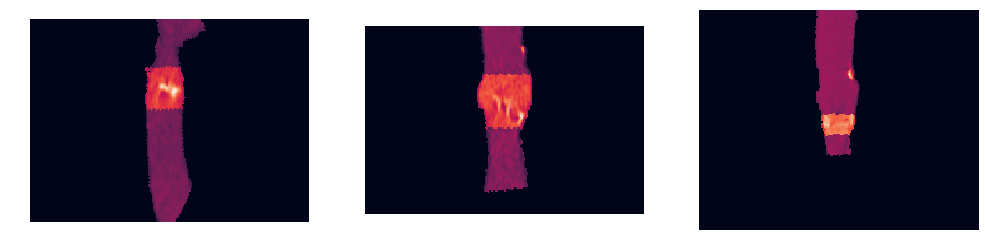

In [17]:
idir = os.path.join('/', 'home', 'ubuntu', 'edata', 'patches')
plt.figure(figsize=(17, 7))
for i in range(3):
    path = np.random.choice(glob(os.path.join(idir, '*')))
    mask = np.load(os.path.join(path, 'mask_0.npy'))
    patch = np.load(os.path.join(path, 'pathc_0.npy'))
    plt.subplot(1, 3, i + 1)
    plt.imshow(patch + mask)
    plt.axis('off');

# Train valve segmentation model

In [28]:
! python scripts/train_valve_segmentation.py -h

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
usage: train_valve_segmentation.py [-h] [--epochs E] mdir mpath

Train valve segmentation model.

positional arguments:
  mdir        directory with prepared data (should contains mask_*.npy)
  mpath       path to the model

optional arguments:
  -h, --help  show this help message and exit
  --epochs E  maximum number of epochs to be trained


In [19]:
! python scripts/train_valve_segmentation.py ~/edata/patches/ ../DM_Data/RIII_test_model/mvlv --epochs=2

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Epoch 1/2
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
2018-02-15 19:25:31.378430: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-02-15 19:25:31.468223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:892] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning 

# Predict valve segmentation

In [20]:
! python scripts/predict_valve_segmentation.py -h

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
usage: predict_valve_segmentation.py [-h] [--n N] idir odir mpath

Valve segmentation model inference over prepared dataset

positional arguments:
  idir        directory with prepared data (should contains mask_*.npy)
  odir        output directory
  mpath       path to the model

optional arguments:
  -h, --help  show this help message and exit
  --n N       maximum number of epochs to be trained


In [21]:
! python scripts/predict_valve_segmentation.py ~/edata/patches ~/edata/valve_output ~/edata/xception_valve --n=4

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
2018-02-15 19:26:03.016529: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-02-15 19:26:03.100923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:892] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-02-15 19:26:03.101258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1030] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:1e.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2018-02-15 19:26:03.101289: I tensorflow/core/common_runtime/gpu/gpu_de

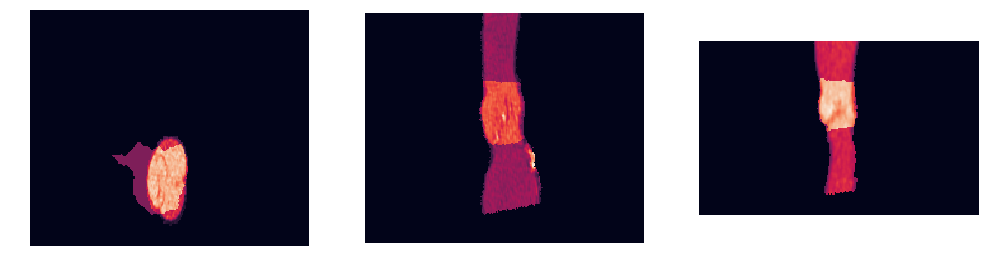

In [27]:
idir = os.path.join('/', 'home', 'ubuntu', 'edata', 'valve_output')
mdir = os.path.join('/', 'home', 'ubuntu', 'edata', 'patches')

plt.figure(figsize=(17, 7))
for i in range(3):
    path = np.random.choice(glob(os.path.join(idir, '*')))
    patch = np.load(os.path.join(mdir, os.path.basename(path)[:-4], 'pathc_3.npy'))
    predict = np.load(os.path.join(path))
    plt.subplot(1, 3, i + 1)
    plt.imshow(patch[:predict.shape[0], :predict.shape[1]] + predict[:patch.shape[0], :patch.shape[1]])
    plt.axis('off');

# Prepare features

In [30]:
! python scripts/prepare_features.py -h

usage: prepare_features.py [-h] [--labels_path LP] [--exclude_paths EP]
                           [--n N]
                           idir zpdir valve_path opath

Prepare features for valve size classification.

positional arguments:
  idir                input directory
  zpdir               directory should contains zis.npy and prods.npy
  valve_path          path to the valve.csv
  opath               output directory

optional arguments:
  -h, --help          show this help message and exit
  --labels_path LP    path to the REPRISE III Sizes.xlsx
  --exclude_paths EP  path to the pickled version of excluded paths
  --n N               maximum number of samples to be processed


In [ ]:
! python scripts/prepare_features.py ~/edata/ ~/cdata/DM_Data/RIII valve.csv ~/edata/features.csv --labels_path=../DM_Data/REPRISE\ III\ Sizes.xlsx --exclude_paths=exclude_paths --n=3

In [33]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
import pandas as pd
from tqdm import tqdm
import pickle


features = pd.read_csv('features')
features = features.drop(['Unnamed: 0'], axis=1)

labels = features[['class']]
for label in labels['class'].unique():
    labels[label] = features['class'] == label
labels = labels.drop(['class'], axis=1).values
features = features.drop(['class', 'seriesuid'], axis=1).values

loo = LeaveOneOut()
predicted = dict()
gt = list()
clfs = [
        GradientBoostingClassifier(n_estimators=3, max_depth=2, random_state=10)
    ]
for clf in clfs:
    predicted[str(clf.__class__)] = list()
    for split, lo in tqdm(loo.split(features)):
        clf.fit(features[split], np.argmax(labels[split], axis=1))

        predicted[str(clf.__class__)].append(clf.predict_proba(features[lo]))
        
for i, clf in enumerate(clfs):
    pred = np.array(predicted[str(clf.__class__)])
    pred = np.argmax(pred, axis=-1)
    gt = np.argmax(labels, axis=-1)
    print((len(labels) - (np.abs(np.squeeze(pred) - gt) > 0).sum()) / len(labels))


pickle.dump(clfs, open('../clfs', 'wb'))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
127it [00:00, 187.52it/s]

0.748031496063
